In [20]:
import requests
import copy
from music21 import *
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

In [21]:
# Download files - don't use this code to scrape

# for i in range(1,25):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkI/{}'.format(file_name)
#     r = requests.get(url)

#     with open(file_name, 'wb') as f:
#         f.write(chunk)

# for i in range(1,13):
#     file_name = 'Fugue{}.mid'.format(i)
#     url = 'http://www.bachcentral.com/WTCBkIIx/{}'.format(file_name)
#     r = requests.get(url)
#     file_name = 'Fugue{}_wtcii.mid'.format(i)
#     with open(file_name, 'wb') as f:
#         f.write(chunk)

In [22]:
def clean_zero_durations(midi_data):
    for stream in range(len(midi_data)):
        for element in range(len(midi_data[stream])):
            current_element = midi_data[stream][element]
            if isinstance(current_element, note.Note) or isinstance(current_element, chord.Chord) or isinstance(current_element, note.Rest):
                if current_element.duration.quarterLength == 0:
                    midi_data[stream][element].quarterLength = 0.125
    return midi_data

def print_zero_midi_data(midi_data):
    for stream in range(len(midi)):
        for element in range(len(midi[stream])):
            current_element = midi[stream][element]
            if current_element.duration.quarterLength == 0:
                print(midi[stream][element].quarterLength, current_element)

def print_midi_data(midi_data):
    for stream in range(len(midi_data)):
        current_stream = midi_data[stream].notesAndRests
        for element in range(len(current_stream)):
            current_element = current_stream[element]
            print(current_element.duration.type, current_element, current_element.duration.quarterLength)

In [27]:
def get_notes(midi_data, begin=False, end=False):
    
    if begin:
        features = ['begin']
    else:
        features = []
        
    midi_data = midi_data.chordify()
    for element in midi_data.notesAndRests:
        if isinstance(element, note.Rest):
            features.append('{}%{}'.format(element.duration.quarterLength, element.name))
        elif isinstance(element, note.Note):
            features.append('{}%{}'.format(element.duration.quarterLength, element.namewithOctave))            
        elif isinstance(element, chord.Chord):
            current_chord = [str(element.duration.quarterLength)]
            for chord_note in element:
                if (chord_note.tie) and (chord_note.tie.type == 'start') or not(chord_note.tie):
                    current_chord.append(chord_note.nameWithOctave)
            if len(current_chord) == 1:
                current_chord.append('rest')
            features.append('%'.join(current_chord))

    if end:
        features.append('end')
        
    return features

In [39]:
def load_data():
    notes_data = []
    cwd = os.getcwd()
    for path in Path(cwd).glob('**/*.mid'):
        # because path is object not string
        file = str(path)
        try:
            midi = converter.parse(file)
            midi = clean_zero_durations(midi)
            notes = get_notes(midi, False, False)
            notes_data.extend(notes)
        except:
            print(file)
    return notes_data

In [40]:
notes_data = load_data()

/Users/Andrew/Desktop/bach_fugues_well_tempered/midi_files/fugue12.mid
/Users/Andrew/Desktop/bach_fugues_well_tempered/midi_files/fugue19.mid
/Users/Andrew/Desktop/bach_fugues_well_tempered/midi_files/fugue6.mid


In [42]:
## https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
len(notes_data)

21521

In [31]:
df = pd.DataFrame(notes_data)
df.columns = ['notes']
df['count'] = df.groupby('notes')['notes'].transform('count')

Text(0.5,1,'Histogram of number of times a note combination appears')

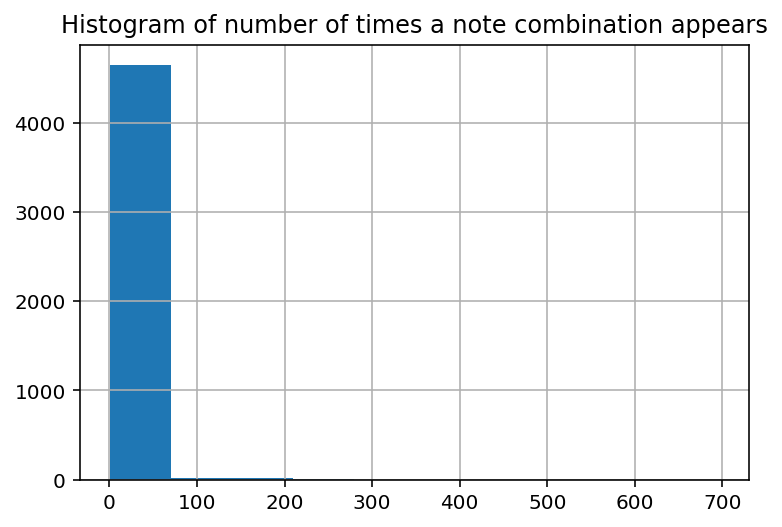

In [32]:
df.drop_duplicates()['count'].hist()
plt.title('Histogram of number of times a note combination appears')

In [33]:
# create mapping of unique chars to integers
chars = sorted(list(set(notes_data)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

In [34]:
n_chars = len(notes_data)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  21589
Total Vocab:  4684


In [12]:
# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = notes_data[i:i + seq_length]
    seq_out = notes_data[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  21489


In [13]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# normalize
X = X / float(n_vocab)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [35]:
# define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [36]:
# define the checkpoint
# filepath="weights-improvement-SunMay13-11:26AM-{epoch:02d}-{loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]

In [37]:
# model.fit(X, y, epochs=50, batch_size=128, callbacks=callbacks_list)

In [38]:
# load the network weights
filename = "weights-improvement-SunMay13-11_26AM-28-2.6342.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

ValueError: Dimension 1 in both shapes must be equal, but are 4684 and 6178. Shapes are [256,4684] and [256,6178]. for 'Assign_7' (op: 'Assign') with input shapes: [256,4684], [256,6178].

In [ ]:
int_to_char = dict((i, c) for i, c in enumerate(chars))

In [ ]:
note_sequence = []

# pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")
# generate characters
for i in range(1000):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    note_sequence.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")

In [ ]:
note_sequence

In [ ]:
def from_string_to_music(note_sequence):
    midi_stream = stream.Stream()
    for entry in note_sequence:
        if entry == 'begin' or entry == 'end':
            continue

        current_notes = entry.split('%')
        duration = float(eval(current_notes[0]))

        if current_notes[1] == 'rest':
            midi_stream.append(note.Rest(quarterLength=duration))
        else:
            chord_notes = []
            for entry in current_notes[1:]:
                chord_notes.append(note.Note(quarterLength=duration, nameWithOctave=entry))
            midi_stream.append(chord.Chord(chord_notes))

    midi_stream.write('midi', fp='test_output.mid')
    return midi_stream

In [ ]:
midi_stream = from_string_to_music(note_sequence)

for entry in midi_stream.notesAndRests:
    print(entry)